### Assignment 1B: Linear regression




**In this assignment, we will see:**
- how to assess the impact of an experimental factor on our experimental measurement using **linear regression**
- how to take into account the hetereogeneity of our sample population using **linear mixed models**

<div class="alert alert-block alert-warning">
<b>Preparing for this assignment:</b> 

The following resources will help you to get ready to complete this assignment. 
<ul>
    <li>Watch <a href="https://www.youtube.com/watch?v=KsVBBJRb9TE" target="_blank">this video</a> and then follow with <a href="https://www.youtube.com/watch?v=xIDjj6ZyFuw" target="_blank">this video</a> to learn the concepts about simple linear regression</li>
    <li>For a complementary look on linear regression that put its into the more general framework of model fitting, watch <a href="https://www.youtube.com/watch?v=9JfXKmVB6qc" target="_blank">this video</a> (until 15:10) and then follow with <a href="https://www.youtube.com/watch?v=HumajfjJ37E" target="_blank">this video</a> (linear regression by minimizing squared errors) and <a href="https://www.youtube.com/watch?v=8mpNmzLKNfU" target="_blank">this one</a> (linear regression by maximizing likelihood). These are parts of the material for Model Fitting day which are accessible <a href="https://compneuro.neuromatch.io/tutorials/W1D2_ModelFitting/chapter_title.html" target="_blank">here</a>. </li>
    <li> (Very optional) See <a href="https://www.cns.nyu.edu/~eero/NOTES/leastSquares.pdf" target="_blank">these notes</a> from Eero Simoncelli (NYU) if you want to delve more into the mathematics related to linear regression</li>
    <li>Read <a href="https://doi.org/10.1152/jn.00362.2015" target="_blank">this paper</a> (focussing on Experiment 2) to understand the logic of the experimental data that we will analyze</li>
</ul>
</div>

## Load again the working memory dataset


Load the data and organize it in a Pandas dataframe (as in Assignment 1A).

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def circdist_rad(angles1,angles2): #define the name and set the arguments between parentheses
    output = np.angle( np.exp(1j*(angles1-angles2))) ## mathematical operation to get the circular distance
    return output #return the circular distance in radians 

# load the data from github
df = pd.read_csv("https://raw.githubusercontent.com/wimmerlab/MBC-DataAnalysis/main/A0_PythonBasics/Experiment2_all_subjects.csv",sep=' ')

# add errors and CW/CCW info
df['error'] = circdist_rad(df['response'],df['target'])
df['dist_closest'] = circdist_rad(df['distr1'],df['target'])
df['cw'] = df['dist_closest']<0


## 1. Simple linear regression

The analysis so far (in Assignment 1A) was simple and good. However, one thing it did not include was all the detail about the location of non-targets. The design of our experiment was not really binary, with just one degree of freedom for CW or CCW non-targets. Instead, they were located at variable distances both in CW and CCW trials. See this by plotting the histogram of 'dist_closest', the distances between non-target and target items in each trial. 

In [ ]:
???

This variability in 'dist_closest' (X) could be a factor explaining the variability in response error Y.
The appropriate analysis to check this dependency is a “simple linear regression”. A regression tests for the contribution of the variability in an independent variable (here the inter-item distance X, which is independently set by the experimenter) to generating the variability in dependent variable (here the behavioral error Y).


First, we will ignore that data points come from different subjects. Run the analysis for all the data together and obtain the coefficients of the linear regression that fits the data.  We can run this analysis with the function *ols* in **statsmodel.formula.api**. Google it to see how it is used.

By using the dataframe you just have to define the function of the regression that you want to use. Which one is it?

In [15]:
from statsmodels.formula.api import ols

mod = ols(formula = ??? , data=df)
res = mod.fit()

# The coefficients
print('Coefficients:', res.params)


Coefficients: Intercept      -0.027865
dist_closest    0.069416
dtype: float64


Can we say that the regression is significant? (i.e. is the slope of the regression line significantly different from zero?). This is an inference question that we will see if we can resolve, we will first need to test if the assumptions of the inference are met in our data. But before that, we can get a first sense of our regression result graphically. Always, graphical representations help in identifying trends in your data or pointing towards possible problems.

Use the regression coefficients to plot the regression line on top of the actual data points (X,Y). Is the result in agreement with the analysis?

In [ ]:

x_data = ??? # set x-values for your prediction, these can be the same X values used for estimation or others for your desired range of prediction
y_data = ??? + ??? * x_data # given the values in x_data, predict y_data values from our estimated linear model parameters in *res_params*
plt.plot(x_data, y_data, 'r') # plot the model prediction with a line
plt.plot( ???, ???, 'bo') # now plot the true data from our dataframe df as dots
plt.ylim(-0.5, 0.5); # plot limits


Should we believe this slope? Is our data really supporting a slope different than zero? 
Before we actually do inference on the parameter estimates of the model, we need to worry about the assumptions of the test. Regression is a parametric test and assumes a **normal distribution of independent residual errors**. We usually perform two checks: we test independence of errors by plotting residuals against the independent variable, and we check the Gaussian distribution of residuals with *probplot*. Watch the [second video on linear regression above](https://www.youtube.com/watch?v=xIDjj6ZyFuw) to understand these checks.

In [ ]:

from scipy.stats import probplot

plt.subplot(1,2,1)
plt.scatter(???, res.resid_pearson) # we first plot the residuals versus the independent variable X in a scatter plot
plt.ylabel('model residuals')
plt.xlabel('model''s independent variable (X)')
plt.subplot(1,2,2)
probplot(res.resid_pearson, plot=plt); # then we plot the QQ-plot to check Gaussian statistics
plt.tight_layout()


Errors do not appear to have any strong dependency on X (left graph), but the graph on the right shows that the distribution of residuals is slightly non-Gaussian. In this case this is a very minor deviation and we would generally validate the assumptions of our inference tests, here. But let's for now worry about whether this could violate the assumptions of the linear regression method. Could it be about outliers?


We will thus control the outliers to make sure that they are not affecting the result. We thus repeat the analysis without outliers. To identify outliers we will use the *zscore* function. Google about it to learn its meaning. A typical threshold for outliers is 3 standard deviations from the mean, in either direction:

In [ ]:

from scipy.stats import zscore # we import the zscore function

# get the number of upper outliers 
upp_out = sum(zscore(df.error) > 3 )
print('Number of Upper outliers : ' +str(upp_out))

# get the number of lower outliers
low_out = sum(zscore(df.error) < -3)
print('Number of Lower outliers : ' +str(low_out))

# now get the dataset excluding outliers
rem_out = abs(zscore(df.error)) < 3. # boolean for the non-outlier data rows
df_out = df[rem_out].reset_index(drop=True) # data without outliers

# and we run the regression analysis
mod_out = ols(formula='error ~ dist_closest', data=df_out)
res_out = mod_out.fit()

#and we test if the new data conforms to the assumptions of the inference test
plt.subplot(1,2,1)
plt.plot(df_out.dist_closest, res_out.resid_pearson,'.')
plt.ylabel('model residuals')
plt.xlabel('model''s independent variable (X)')
plt.subplot(1,2,2)
probplot(res_out.resid_pearson, plot=plt); # then we plot the QQ-plot to check Gaussian statistics
plt.tight_layout()


After removing 7 outliers in our data, we now find that the residuals of our model are distributed following a Gaussian distribution approximately, as the blue dots fall on the red line.

The three examples in the figure below illustrate 3 different situations with outliers. In case 1, the outlier is totally determining the regression so that if we drop it, the effect is gone (we cannot reject the horizontal line as best fit). In this case the outlier HAS to be dropped and you are not allowed to report any effect. This are the bad outliers. In case 2, the outlier has an effect on your data (the slope of the regression changes with and without the outlier, and the quality of the fit, too), but it does not change qualitatively your conclusions (still positive regression slope). You are allowed to remove the outlier but you should report the two values of the slope, when you have it and when you don't. The best case is case 3, where independently of whether you include the outlier or not, the result of your analysis is the same. In this case you can drop the outlier safely. In any case, you have to report that there was an outlier and that you dropped it for such and such reasons.

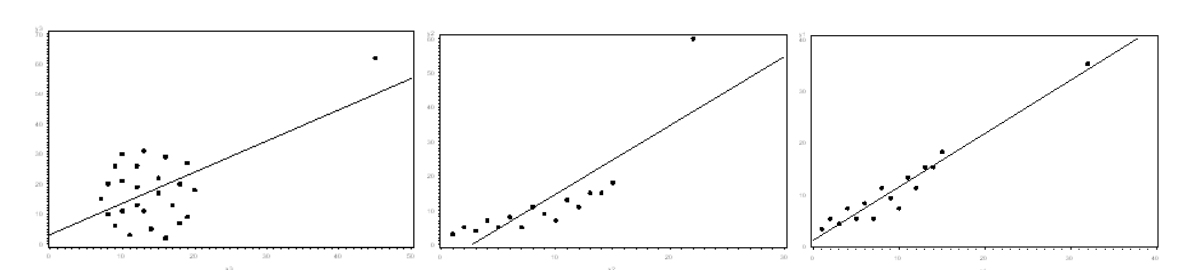

So once we are satisfied that the modeling of our data conforms to the assumptions of our inference tests, we are safe to inspect and interpret the results of the inference on the estimated parameters of our linear model:

In [ ]:

# we show the results
print( res_out.summary() )
print()
print("p-value for the slope: p=" + str(res_out.pvalues[1]))
print()


What do you interpret from this table? Open a *Markdown cell* here below and specify your interpretations. If you look again at [the video indicated above](https://www.youtube.com/watch?v=xIDjj6ZyFuw), you will get ideas as to how these tables are interpreted.

## 2 Linear regression with categorical variables

Now we realize that in the regression analysis we included data points that were not truly independent, as they were collected in 9 different subjects. We thus want to include that part of the design in the regression analysis, as it could increase the statistical power. When we do that, we will need to use a **general linear model**, a linear model that includes factors of mixed nature, some being categorical and some continuous (as in regression). This is the most common situation and a general analysis tool that encompasses all the previous techniques in this assignment. To include subject identity in the design of a general linear model, we need to define the regressors as categorical, because otherwise it would be regressing orderly along our subject numbers. This is really simple by using the formula. Writting C('factor') instead of 'factor' makes it categorical. Implement that in the regression, test the assumptions of the inference tests and then get the inference table for the model estimates.




In [ ]:
# we define and estimate the model
mod_sub = ols(formula= ??? , data=df_out)
res_sub = mod_sub.fit()

# we assess graphically if the model residuals conform to inference assumptions (just as we did before!)
???
???
???
???
???
???
???


In [21]:
assert np.round(res_sub.params[6],5)==-0.01813

In [22]:
# we print the results of the inference
print( res_sub.summary() )
print("p-value for the slope: p=" + str(res_sub.pvalues[???]))

                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.773
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           0.000113
Time:                        18:20:28   Log-Likelihood:                 466.54
No. Observations:                 850   AIC:                            -913.1
Df Residuals:                     840   BIC:                            -865.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.0019      0.01


Can you find the p-value for the regressor of interest? Why are the other regressors not “of interest”? Why do we include them, then? 


In this assignment we have dealt with adding regressors that are not of interest *per se* in our analysis, but that we include in order to improve the model fit for our factor of interest. This is the classic condition for the “subject” part of the design (which, in addition could be treated as a random factor, try and read about that when you get to use these methods in your own data). In Assignment 2, we will work with designs that have several factors of interest, and we will analyze the concept of interaction.

## 3. Extension exercises (optional)

### 3.1 Linear mixed models

We used categorial variables to model differences between subjects in our experiment. As the number of subjects increases, this becomes a not very optimal approach to modeling subject-to-subject variability in our data because we will include more and more parameters in the model (one per subject, essentially). Since we are typically not interested in the specific parameter of one or another subject but on a general modeling of the population variability, what mathematicians have figured is that these factors in the design should be modeled as "random factors" so that instead of estimating one parameter per subject, one would estimate the variance of the population (assuming, again, Gaussian statistics). In this way, one parameter of variance will take care of the variability across participants. Linear models that include both fixed factors (one parameter per regressor) and random factors (a variance parameter accounting for a family of regressors) are called "mixed models". These are usually the way that we should model subjects in our designs.

Explore how to do that in this extension exercise. This is a bit tricky as these methods are advanced and are not very well developed in Python. The R language is a lot better adapted for advanced statistics methods. You have two choices:
1) Use the function *mixedlm* in the Python library **statsmodels.formula.api**. This should be very parallel to what you just did, but you need to choose the right options for *mixedlm*

2) Use the Python library **pymer4.models**, which gives you access to R functions from within Python. You can then import the function *Lmer* and call it specifying the fixed and random factors in your design (check the documentation). This is a more powerful approach, because of the simplicity of the syntax and all the power of R that you can invoke.

### 3.2 Testing the linearity of the regression model

Now if you think carefully, the linear regression analysis above was not really fair. We cannot really conclude that small differences in distance between target and distractor affect the error bias beyond the CW/CCW difference. This is because the data has such a strong cluster structure and our linear analysis may just be picking the two clusters and not finer structrure within clusters. In order to really see if the small variance of target-distraction distances had an impact in error bias, we should look at regression within each of the two CW/CCW categories. One way to address that is to fold the errors: if we take negative target-distraction distances and "fold" them onto the positive axis, while the corresponding y values (error) are also changed in sign, we will collapse the two clouds onto one single compact cloud while keeping the possible linear relationship. Then we can run a linear regression analysis on this data.

Run this analysis with any of the linear regression models that we have tried above.
